Шаг 1. Создать Airflow DAG, который будет ежедневно выполнять следующие действия:

загружать данные из файлов с локальной директории в соответствующие таблицы (параллельные task-и):
о клиентах — customer;
о продуктах — product;
о заказах — orders;
связывающие заказы и продукты — order_items.

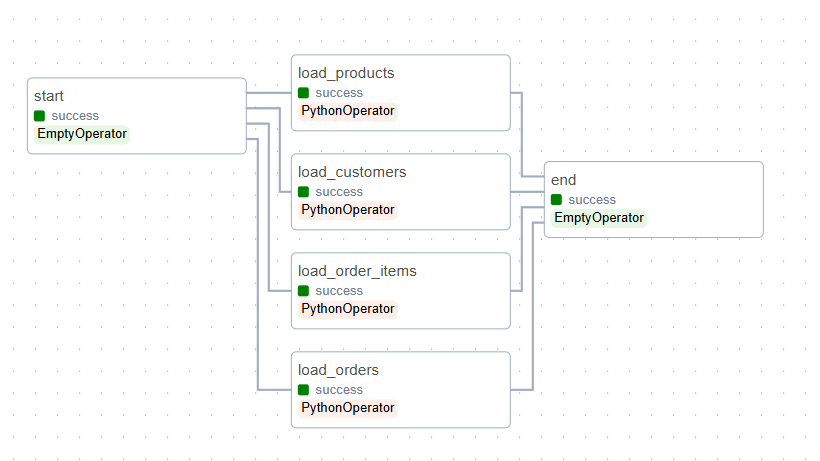

Шаг 2. Далее выполнить следующие запросы, записав ответы в отдельные файлы (параллельные task):
Найти имена и фамилии клиентов с ТОП-3 минимальной и ТОП-3 максимальной суммой транзакций за весь период (учесть клиентов, у которых нет заказов).
Найти ТОП-5 клиентов (по общему доходу) в каждом сегменте благосостояния (wealth_segment). Вывести имя, фамилию, сегмент и общий доход. Если в сегменте менее 5 клиентов, вывести всех.

Шаг 3. Проверить, что запросы из пункта выше не вернули нулевое количество строк. В случае непрохождения проверки отправить уведомление на почту.

Шаг 4. Вывести сообщение об успешном или неуспешном выполнении DAG.

In [ ]:
from datetime import datetime, timedelta
from airflow import DAG
from airflow.operators.python import PythonOperator
from airflow.operators.dummy import DummyOperator
from airflow.providers.postgres.hooks.postgres import PostgresHook
from airflow.utils.email import send_email
import pandas as pd
import os
import logging

logger = logging.getLogger(__name__)


CSV_FILES = {
    'customers': {'filename': 'customers.csv', 'delimiter': ';'},
    'products': {'filename': 'products.csv', 'delimiter': ','},
    'orders': {'filename': 'orders.csv', 'delimiter': ','},
    'order_items': {'filename': 'order_items.csv', 'delimiter': ','}
}

EMAIL_TO = "riabokon.nv@phystech.edu"
DATA_PATH = "/opt/airflow/data"
RESULTS_PATH = "/opt/airflow/results"

def load_csv_to_postgres(table_name, csv_filename, delimiter):
    try:
        csv_path = f"{DATA_PATH}/{csv_filename}"
        logger.info(f"Загрузка {csv_filename} в таблицу {table_name}")

        df = pd.read_csv(csv_path, delimiter=delimiter)
        logger.info(f"Прочитано {len(df)} строк, {len(df.columns)} колонок")

        hook = PostgresHook(postgres_conn_id="postgres_default")
        engine = hook.get_sqlalchemy_engine()

        df.to_sql(
            name=table_name,
            con=engine,
            if_exists="replace",
            index=False
        )

        logger.info(f"Успешно загружено в {table_name}: {len(df)} строк")
        return len(df)

    except Exception as e:
        logger.error(f"Ошибка при загрузке {table_name}: {e}")
        raise


def execute_query_1_top_customers(**context):
    try:
        hook = PostgresHook(postgres_conn_id="postgres_default")

        query = """
        WITH customer_transactions AS (
            SELECT
                c.customer_id,
                c.first_name,
                c.last_name,
                COALESCE(SUM(oi.quantity * oi.item_list_price_at_sale), 0) as total_spent
            FROM customers c
            LEFT JOIN orders o ON c.customer_id = o.customer_id
            LEFT JOIN order_items oi ON o.order_id = oi.order_id
            GROUP BY c.customer_id, c.first_name, c.last_name
        )
        -- ТОП-3 максимальная сумма
        (SELECT
            first_name,
            last_name,
            total_spent,
            'TOP_MAX' as category
        FROM customer_transactions
        ORDER BY total_spent DESC
        LIMIT 3)

        UNION ALL

        -- ТОП-3 минимальная сумма
        (SELECT
            first_name,
            last_name,
            total_spent,
            'TOP_MIN' as category
        FROM customer_transactions
        ORDER BY total_spent ASC
        LIMIT 3)

        ORDER BY category DESC, total_spent DESC;
        """

        df = hook.get_pandas_df(query)

        os.makedirs(RESULTS_PATH, exist_ok=True)
        output_path = f"{RESULTS_PATH}/top_customers.csv"
        df.to_csv(output_path, index=False)

        logger.info(f"Запрос 1 выполнен: {len(df)} строк")
        logger.info(f"Файл сохранен: {output_path}")

        context['ti'].xcom_push(key='query1_rows', value=len(df))
        context['ti'].xcom_push(key='query1_data', value=df.head().to_dict())

        return len(df)

    except Exception as e:
        logger.error(f"Ошибка в запросе 1: {e}")
        raise

def execute_query_2_wealth_segment(**context):
    try:
        hook = PostgresHook(postgres_conn_id="postgres_default")

        query = """
        WITH customer_income AS (
            SELECT
                c.customer_id,
                c.first_name,
                c.last_name,
                c.wealth_segment,
                COALESCE(SUM(oi.quantity * oi.item_list_price_at_sale), 0) as total_income
            FROM customers c
            LEFT JOIN orders o ON c.customer_id = o.customer_id
            LEFT JOIN order_items oi ON o.order_id = oi.order_id
            GROUP BY c.customer_id, c.first_name, c.last_name, c.wealth_segment
        ),
        ranked_customers AS (
            SELECT
                first_name,
                last_name,
                wealth_segment,
                total_income,
                ROW_NUMBER() OVER (
                    PARTITION BY wealth_segment
                    ORDER BY total_income DESC
                ) as rank_in_segment
            FROM customer_income
            WHERE wealth_segment IS NOT NULL
        )
        SELECT
            first_name,
            last_name,
            wealth_segment,
            total_income,
            rank_in_segment
        FROM ranked_customers
        WHERE rank_in_segment <= 5
        ORDER BY wealth_segment, rank_in_segment;
        """

        df = hook.get_pandas_df(query)

        os.makedirs(RESULTS_PATH, exist_ok=True)
        output_path = f"{RESULTS_PATH}/wealth_segment_top5.csv"
        df.to_csv(output_path, index=False)

        logger.info(f"Запрос 2 выполнен: {len(df)} строк")
        logger.info(f"Файл сохранен: {output_path}")
        context['ti'].xcom_push(key='query2_rows', value=len(df))
        context['ti'].xcom_push(key='query2_data', value=df.head().to_dict())

        return len(df)

    except Exception as e:
        logger.error(f"Ошибка в запросе 2: {e}")
        raise

def check_query_results(**context):
    try:
        ti = context['ti']

        query1_rows = ti.xcom_pull(task_ids='query_1_task', key='query1_rows')
        query2_rows = ti.xcom_pull(task_ids='query_2_task', key='query2_rows')

        logger.info("Проверка результатов запросов:")
        logger.info(f"  Запрос 1 (ТОП клиенты): {query1_rows} строк")
        logger.info(f"  Запрос 2 (ТОП по сегментам): {query2_rows} строк")

        errors = []

        if not query1_rows or query1_rows == 0:
            errors.append("Запрос 1 вернул 0 строк - нет данных о клиентах")

        if not query2_rows or query2_rows == 0:
            errors.append("Запрос 2 вернул 0 строк - нет данных по сегментам благосостояния")

        if errors:
            error_message = "; ".join(errors)
            logger.error(f"Проверка не пройдена: {error_message}")
            email_subject = "Ошибка в DAG module6_complete_final"
            email_body = f"""
            <h2>Ошибка выполнения DAG module6_complete_final</h2>
            <p>Время: {datetime.now()}</p>
            <p>Ошибки:</p>
            <ul>
                <li>{'</li><li>'.join(errors)}</li>
            </ul>
            <p>Пожалуйста, проверьте данные и выполнение DAG.</p>
            """

            try:
                send_email(
                    to=EMAIL_TO,
                    subject=email_subject,
                    html_content=email_body
                )
                logger.info(f"Email-уведомление отправлено на {EMAIL_TO}")
            except Exception as email_error:
                logger.error(f"Ошибка при отправке email: {email_error}")

            raise ValueError(f"Проверка не пройдена: {error_message}")
        else:
            logger.info("Все проверки пройдены успешно!")
            return True

    except Exception as e:
        logger.error(f"Ошибка при проверке результатов: {e}")
        raise

def final_dag_status(**context):
    try:
        ti = context['ti']

        query1_rows = ti.xcom_pull(task_ids='query_1_task', key='query1_rows', default=0)
        query2_rows = ti.xcom_pull(task_ids='query_2_task', key='query2_rows', default=0)

        logger.info("=" * 60)
        logger.info("ФИНАЛЬНЫЙ СТАТУС ВЫПОЛНЕНИЯ DAG")
        logger.info("=" * 60)

        if query1_rows > 0 and query2_rows > 0:
            logger.info("DAG ВЫПОЛНЕН УСПЕШНО!")
            logger.info(f"Результаты:")
            logger.info(f"  • Запрос 1: {query1_rows} строк")
            logger.info(f"  • Запрос 2: {query2_rows} строк")
            logger.info(f"Файлы сохранены в: {RESULTS_PATH}/")

            if os.path.exists(RESULTS_PATH):
                files = os.listdir(RESULTS_PATH)
                logger.info(f"Созданные файлы: {', '.join(files)}")
        else:
            logger.error("DAG ВЫПОЛНЕН С ОШИБКАМИ!")
            logger.error(f"  • Запрос 1: {query1_rows} строк")
            logger.error(f"  • Запрос 2: {query2_rows} строк")

        logger.info("=" * 60)

        return "SUCCESS" if query1_rows > 0 and query2_rows > 0 else "FAILED"

    except Exception as e:
        logger.error(f"Ошибка при выводе финального статуса: {e}")
        return "FAILED"

default_args = {
    "owner": "student",
    "depends_on_past": False,
    "start_date": datetime(2024, 1, 1),
    "retries": 1,
    "retry_delay": timedelta(minutes=5),
    "email_on_failure": True,
    "email_on_retry": False,
}

with DAG(
    dag_id="ryabokon_nv_module6",
    default_args=default_args,
    description="Ежедневная загрузка данных и аналитика для модуля 6",
    schedule_interval="@daily",
    catchup=False,
    tags=["module6", "homework", "analytics", "postgres"]
) as dag:

    start = DummyOperator(task_id="start")

    load_customers = PythonOperator(
        task_id="load_customers",
        python_callable=load_csv_to_postgres,
        op_kwargs={
            "table_name": "customers",
            "csv_filename": CSV_FILES['customers']['filename'],
            "delimiter": CSV_FILES['customers']['delimiter']
        }
    )

    load_products = PythonOperator(
        task_id="load_products",
        python_callable=load_csv_to_postgres,
        op_kwargs={
            "table_name": "products",
            "csv_filename": CSV_FILES['products']['filename'],
            "delimiter": CSV_FILES['products']['delimiter']
        }
    )

    load_orders = PythonOperator(
        task_id="load_orders",
        python_callable=load_csv_to_postgres,
        op_kwargs={
            "table_name": "orders",
            "csv_filename": CSV_FILES['orders']['filename'],
            "delimiter": CSV_FILES['orders']['delimiter']
        }
    )

    load_order_items = PythonOperator(
        task_id="load_order_items",
        python_callable=load_csv_to_postgres,
        op_kwargs={
            "table_name": "order_items",
            "csv_filename": CSV_FILES['order_items']['filename'],
            "delimiter": CSV_FILES['order_items']['delimiter']
        }
    )

    query_1_task = PythonOperator(
        task_id="query_1_task",
        python_callable=execute_query_1_top_customers
    )

    query_2_task = PythonOperator(
        task_id="query_2_task",
        python_callable=execute_query_2_wealth_segment
    )

    check_results_task = PythonOperator(
        task_id="check_results_task",
        python_callable=check_query_results
    )

    final_status_task = PythonOperator(
        task_id="final_status_task",
        python_callable=final_dag_status
    )

    end = DummyOperator(task_id="end")
    start >> [load_customers, load_products, load_orders, load_order_items]

    load_customers >> query_1_task
    load_products >> query_1_task
    load_orders >> query_1_task
    load_order_items >> query_1_task

    load_customers >> query_2_task
    load_products >> query_2_task
    load_orders >> query_2_task
    load_order_items >> query_2_task

    [query_1_task, query_2_task] >> check_results_task >> final_status_task >> end

In [2]:
from google.colab import files
uploaded = files.upload()

Saving top_customers.csv to top_customers.csv
Saving wealth_segment_top5.csv to wealth_segment_top5.csv


In [7]:
import pandas as pd
import numpy as np
df1 = pd.read_csv('top_customers.csv')
df1


,first_name,last_name,total_spent,category
0,Eileen,Ilchenko,0.00,TOP_MIN
1,Zebedee,Christal,0.00,TOP_MIN
2,Erl,Markel,0.00,TOP_MIN
3,Jillie,Fyndon,136632.46,TOP_MAX
4,Jeffry,Slowly,133657.06,TOP_MAX
5,Tye,Doohan,129789.94,TOP_MAX


In [6]:
df2 = pd.read_csv('wealth_segment_top5.csv')
df2

,first_name,last_name,wealth_segment,total_income,rank_in_segment
0,Jeffry,Slowly,Affluent Customer,133657.06,1
1,Tye,Doohan,Affluent Customer,129789.94,2
2,Herc,McIlhone,Affluent Customer,107476.68,3
3,Queenie,Flips,Affluent Customer,106182.33,4
4,Jessamine,Brazear,Affluent Customer,98618.77,5
5,Mercy,Wilsone,High Net Worth,109334.74,1
6,Lockwood,Exroll,High Net Worth,92405.18,2
7,Linell,NaN,High Net Worth,91450.18,3
8,Gayelord,Lipman,High Net Worth,90493.06,4
9,Jonell,Gon,High Net Worth,87555.70,5


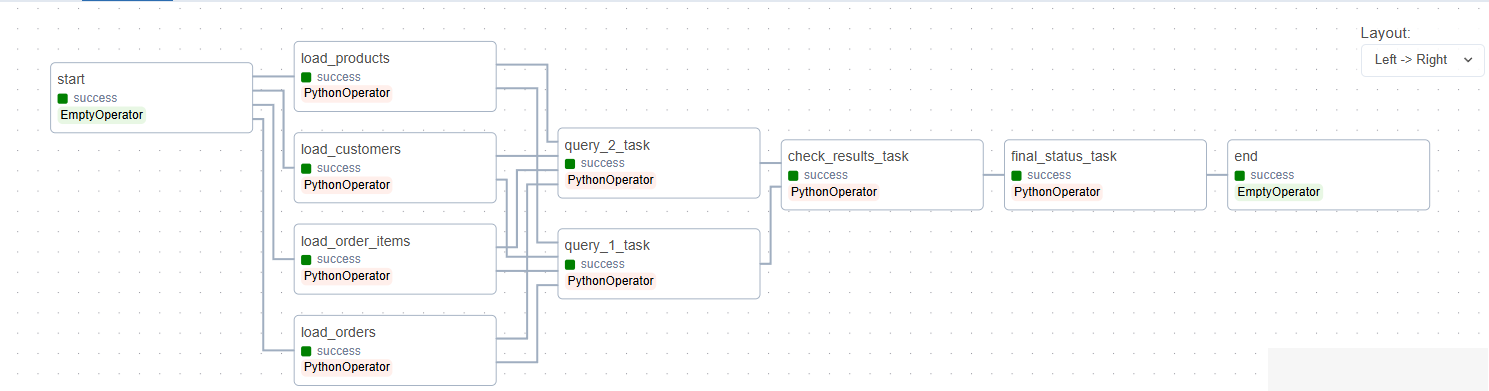![image.png](
)